# TLDR
Given a camera's (Distance, FocalLength, SensorWidth, SensorHeight)

Predict distortion parameters (K1, K2)


# Data directory

Put your CSV files in this directory. MMMMMmmmm OK?

In [3]:
from pathlib import Path
lensdatadir = Path('g:/My Drive/Projects/camflex/data')

import numpy as np
# Set seeds for reproducibility
np.random.seed(42)


In [4]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

# Mount Google Drive locally

In [ ]:
%%skip
from google.colab import drive
drive.mount('/content/drive')
lensdatadir = Path('/content/drive/My Drive/Projects/camflex/data')
%pip install onnxmltools onnxconverter_common

In [5]:
modeldir = lensdatadir.parent / 'models'
print('Model directory is', modeldir)

Model directory is g:\My Drive\Projects\camflex\models


# Test if we can see `lensdatadir`

In [6]:
# prompt: test if directory exists

import os

def directory_exists(path):
  """Checks if a directory exists.

  Args:
    path: The path to the directory.

  Returns:
    True if the directory exists, False otherwise.
  """
  return os.path.isdir(path)

# Example usage:

if directory_exists(lensdatadir):
  print(f"Directory '{lensdatadir}' exists.")
else:
  print(f"Directory '{lensdatadir}' does not exist.")


Directory 'g:\My Drive\Projects\camflex\data' exists.


# Convert 3DE JSON to CSV

In [157]:
from pathlib import Path

def extract_lens_and_camera(path):
    path_parts = Path(path).parts  # Use pathlib to get the path components
    if "data" in path_parts:
        data_index = path_parts.index("data")
        if data_index + 2 < len(path_parts):
            lens_name = path_parts[data_index + 2]
            
            # Extract camera name from the filename
            file_name = Path(path).name
            if 'mm__' in file_name and file_name.endswith('.json'):
                camera_name = file_name.split('mm__')[1].split('.json')[0].lstrip('_')
                
                # Check if the camera_name is in the camera_resolutions dictionary
                if camera_name not in camera_resolutions:
                    raise ValueError(f"Camera '{camera_name}' not found in camera_resolutions.")
                
                return lens_name, camera_name
    return None, None

# Example usage
path = Path(r"G:\My Drive\Projects\camflex\data\ZEISS_CP3\ZEISS_CP3_018mm\lens_flame__ZEISS_CP3_018mm__Alexa35_3.3k_6x5.json")
lens_name, camera_name = extract_lens_and_camera(path)
print(f"Lens Name: {lens_name}, Camera Name: {camera_name}")

Lens Name: ZEISS_CP3_018mm, Camera Name: Alexa35_3.3k_6x5


In [179]:
import os
import json
import csv

camera_resolutions = {
    'Alexa35_3.3k_6x5': (3328, 2790),
    'Alexa35_HD': (1920, 1080),
    'Alexa35_OG': (4608, 3164),
    'Alexa65_6.5k_OG': (6560, 3100),
    'AlexaLF_HD': (1920, 1080),
    'AlexaLF_OG': (4448, 3096),
    'AlexaMini_OG': (3424, 2202),
    'AlexaSXT_2.8k': (2880, 2160),
    'PANAVISION_DXL2_4k_FF': (4096, 2160),
    'PANAVISION_DXL2_6k_HD': (5760, 3240),
    'PANAVISION_DXL2_8k_OG': (8192, 4320),
    'PANAVISION_DXL_6.5k_HD': (6144, 3456),
    'RED_Dragon_4k_HD': (3840, 2160),
    'RED_Dragon_FF': (6144, 3160),
    'RED_Mysteriumx_S35_5k_2x1': (5120, 2560),
    'RED_MysteriumX_S35_5k_3x2': (5120, 2560),
    'RED_MysteriumX_S35_5k': (5120, 2560),
    'RED_WeaponS35_4.5k_HD': (4320, 2376),
    'RED_WeaponS35_5.5k_FF': (5632, 2948),
    'RED_WeaponS35_8k_FF': (6144, 3160),
    'SONY_F55': (4096, 2160),
    'SONY_F65': (4096, 2160),
    'SONY_Venice2_3x2_FF': (8640, 5760),
    'SONY_Venice2_FF_3x2': (8640, 5760),
    'SONY_Venice2_5.8k_6x5': (5792, 4854)
}

def convert_json_to_csv(json_file_path):
    lens_name, camera_name = extract_lens_and_camera(json_file_path)

    if camera_name not in camera_resolutions:
        raise ValueError(f"Camera '{camera_name}' not found in camera_resolutions.")
    
    if camera_name == 'SONY_Venice2_3x2_FF':
        camera_name = 'SONY_Venice2_FF_3x2'
    
    if camera_name == 'RED_Mysteriumx_S35_5k_2x1' or camera_name == 'RED_MysteriumX_S35_5k_3x2':
        camera_name = 'RED_MysteriumX_S35_5k'

    pixel_width, pixel_height = camera_resolutions[camera_name]

    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Extract necessary data
    lens_params = data["AutodeskFlame3DELensDistortion"]["LensParams"]
    focus_distances = data["AutodeskFlame3DELensDistortion"]["FocusDistance"]
    model_params = data["AutodeskFlame3DELensDistortion"]["ModelParams"]
    focal_length = data["AutodeskFlame3DELensDistortion"]["FocalLength"]

    sensor_width = lens_params.get("FBackWidth", None)
    sensor_height = lens_params.get("FBackHeight", None)

    # Filter out distances greater than 500000
    filtered_distances = [d for d in focus_distances if d <= 500000]

    # Prepare data for CSV
    csv_data = []

    for i, distance in enumerate(filtered_distances):
        row = {
            "Distance": distance,

            "K1": model_params["Distortion - Degree 2"][i] if i < len(model_params["Distortion - Degree 2"]) else None,
            "K2": model_params["Quartic Distortion - Degree 4"][i] if i < len(model_params["Quartic Distortion - Degree 4"]) else None,
            
            "U2": model_params["U - Degree 2"][i] if i < len(model_params["U - Degree 2"]) else None,
            "U4": model_params["U - Degree 4"][i] if i < len(model_params["U - Degree 4"]) else None,
            "V2": model_params["V - Degree 2"][i] if i < len(model_params["V - Degree 2"]) else None,
            "V4": model_params["V - Degree 4"][i] if i < len(model_params["V - Degree 4"]) else None,
            
            "SensorW": sensor_width,
            "SensorH": sensor_height,
            "FocalLength": focal_length[0] if isinstance(focal_length, list) and focal_length else None,
            "LensName": lens_name,  # Add lens_name as a column
            "CameraName": camera_name,  # Add camera_name as a column
            "PixelWidth": pixel_width,
            "PixelHeight": pixel_height
        }
        csv_data.append(row)

    # Remove the last row
    if csv_data:
        csv_data.pop()

    # Write to CSV
    csv_file_name = os.path.splitext(os.path.basename(json_file_path))[0] + '.csv'
    csv_file_path = os.path.join(os.path.dirname(json_file_path), csv_file_name)
    csv_headers = ["Distance", "K1", "K2", "U2", "U4", "V2", "V4", "SensorW", "SensorH", "FocalLength", "LensName", "CameraName", "PixelWidth", "PixelHeight"]

    with open(csv_file_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_headers)
        writer.writeheader()
        writer.writerows(csv_data)

    print(f"Data successfully written to {csv_file_path}")


In [180]:
from pathlib import Path

# Main function to process all JSON files in a directory recursively
def process_directory(input_dir):
    input_path = Path(input_dir)
    for json_file_path in input_path.rglob("*.json"):
        #print(json_file_path.parent, json_file_path.name)
        convert_json_to_csv(json_file_path)

process_directory(lensdatadir)

Data successfully written to g:\My Drive\Projects\camflex\data\ARRIFLEX-ZEISS_MK\ARRIFLEX-ZEISS_MK_018mm\lens_flame__ARRIFLEX-ZEISS_MK_018mm__Alexa35_3.3k_6x5.csv
Data successfully written to g:\My Drive\Projects\camflex\data\ARRIFLEX-ZEISS_MK\ARRIFLEX-ZEISS_MK_018mm\lens_flame__ARRIFLEX-ZEISS_MK_018mm__Alexa35_HD.csv
Data successfully written to g:\My Drive\Projects\camflex\data\ARRIFLEX-ZEISS_MK\ARRIFLEX-ZEISS_MK_018mm\lens_flame__ARRIFLEX-ZEISS_MK_018mm__Alexa35_OG.csv
Data successfully written to g:\My Drive\Projects\camflex\data\ARRIFLEX-ZEISS_MK\ARRIFLEX-ZEISS_MK_018mm\lens_flame__ARRIFLEX-ZEISS_MK_018mm__Alexa65_6.5k_OG.csv
Data successfully written to g:\My Drive\Projects\camflex\data\ARRIFLEX-ZEISS_MK\ARRIFLEX-ZEISS_MK_018mm\lens_flame__ARRIFLEX-ZEISS_MK_018mm__AlexaLF_HD.csv
Data successfully written to g:\My Drive\Projects\camflex\data\ARRIFLEX-ZEISS_MK\ARRIFLEX-ZEISS_MK_018mm\lens_flame__ARRIFLEX-ZEISS_MK_018mm__AlexaLF_OG.csv
Data successfully written to g:\My Drive\Projec

# Extract the data from the CSV files 🔢

In [7]:
import pandas as pd
from pathlib import Path

# Function to get CSV files in a directory recursively
def get_csv_files(path):
    dir_path = Path(path)
    return [item for item in dir_path.rglob('*.csv')] if dir_path.exists() and dir_path.is_dir() else []

# Function to extract columns and remove rows with missing data
def extract_and_filter_csv_files(path):
    csv_files = get_csv_files(path)
    all_data = []

    for csv_file in csv_files:
        try:
            # Read each CSV file
            df = pd.read_csv(csv_file)
            # Add filename without leading path or extension as a column
            df['filename'] = csv_file.stem
            # Filter out rows with missing data
            initial_row_count = len(df)
            filtered_df = df.dropna()
            rows_dropped = initial_row_count - len(filtered_df)
            if rows_dropped > 0:
                print(f"Dropped {rows_dropped} rows from {csv_file.name}")
            all_data.append(filtered_df)
        except Exception as e:
            print(f"Error processing {csv_file.name}: {e}")

    # Concatenate all filtered dataframes into a single dataframe
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

# Example usage:
training_data = extract_and_filter_csv_files(lensdatadir)

if not training_data.empty:
    print("Training data:")
    print(training_data.head())
else:
    print("No valid data to process.")

if (training_data.isna().any().any()):
    print("There are missing values in the data.")
else:
    print("There are no missing values in the data.")

Training data:
   Distance        K1        K2            U2        U4        V2        V4  \
0      24.0  0.065365 -0.024750  2.477708e-06 -0.000052  0.000100 -0.000130   
1      25.0  0.065464 -0.025015  3.525759e-07 -0.000050  0.000101 -0.000133   
2      26.0  0.065554 -0.025268 -1.661690e-06 -0.000048  0.000102 -0.000137   
3      27.0  0.065701 -0.025736 -5.717650e-06 -0.000044  0.000105 -0.000143   
4      28.0  0.065769 -0.026179 -4.374831e-06 -0.000049  0.000109 -0.000154   

    SensorW  SensorH  FocalLength                 LensName        CameraName  \
0  2.022005  1.69513         1.83  ARRIFLEX-ZEISS_MK_018mm  Alexa35_3.3k_6x5   
1  2.022005  1.69513         1.83  ARRIFLEX-ZEISS_MK_018mm  Alexa35_3.3k_6x5   
2  2.022005  1.69513         1.83  ARRIFLEX-ZEISS_MK_018mm  Alexa35_3.3k_6x5   
3  2.022005  1.69513         1.83  ARRIFLEX-ZEISS_MK_018mm  Alexa35_3.3k_6x5   
4  2.022005  1.69513         1.83  ARRIFLEX-ZEISS_MK_018mm  Alexa35_3.3k_6x5   

   PixelWidth  PixelHeight   

# [Optional] Investigate bad data

In [14]:
# prompt: report which filenames have bad data in columns: K1 K2 Distance SensorW SensorH

def report_bad_data(training_data):
  """Reports filenames with bad data in specific columns.

  Args:
    training_data: Pandas DataFrame containing the data.
  """

  bad_data_filenames = set()

  for column in ['K1', 'K2', 'Distance', 'SensorW', 'SensorH']:
      if column in training_data.columns:
          rows_with_bad_data = training_data[training_data[column].isnull() | (training_data[column] == 0)]
          for filename in rows_with_bad_data['filename'].unique():
              bad_data_filenames.add(filename)

  if bad_data_filenames:
      print("Filenames with bad data in columns K1, K2, Distance, SensorW, or SensorH:")
      for filename in bad_data_filenames:
          print(filename)
  else:
      print("No bad data found in specified columns.")

# Example usage:
if not training_data.empty:
  report_bad_data(training_data)
else:
  print("Training data is empty, nothing to report.")

No bad data found in specified columns.


# Plot data

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Create a global color palette for consistent colors across all figures
unique_camera_names_global = training_data['CameraName'].unique()
color_mapping = dict(zip(unique_camera_names_global, sns.color_palette("colorblind", len(unique_camera_names_global))))

# Open a PdfPages object to save figures
with PdfPages('lens_analysis.pdf') as pdf:
    unique_lens_names = training_data['LensName'].unique()

    for lens_name in unique_lens_names:
        plt.figure(figsize=(18, 12))  # Set figure size
        plt.suptitle(f'Data for Lens Name: {lens_name}', fontsize=14)

        # Filter data for the current lens name
        lens_data = training_data[training_data['LensName'] == lens_name]

        if lens_data.empty:
            continue  # Skip if no data for this lens

        # Distance vs K1
        plt.subplot(3, 2, 1)
        sns.scatterplot(
            data=lens_data,
            x='Distance',
            y='K1',
            hue='CameraName',
            palette=color_mapping,
            s=10,
            alpha=0.7,
            legend=False  # Disable legend for this subplot
        )
        plt.xscale('log')
        plt.xlabel('Distance (log scale)')
        plt.ylabel('K1')
        plt.title('Distance vs K1')

        # Distance vs K2
        plt.subplot(3, 2, 2)
        sns.scatterplot(
            data=lens_data,
            x='Distance',
            y='K2',
            hue='CameraName',
            palette=color_mapping,
            s=10,
            alpha=0.7,
            legend=False  # Disable legend for this subplot
        )
        plt.xscale('log')
        plt.xlabel('Distance (log scale)')
        plt.ylabel('K2')
        plt.title('Distance vs K2')

        # Distance vs U2
        plt.subplot(3, 2, 3)
        sns.scatterplot(
            data=lens_data,
            x='Distance',
            y='U2',
            hue='CameraName',
            palette=color_mapping,
            s=10,
            alpha=0.7,
            legend=False  # Disable legend for this subplot
        )
        plt.xscale('log')
        plt.xlabel('Distance (log scale)')
        plt.ylabel('U2')
        plt.title('Distance vs U2')

        # Distance vs V2
        plt.subplot(3, 2, 4)
        sns.scatterplot(
            data=lens_data,
            x='Distance',
            y='V2',
            hue='CameraName',
            palette=color_mapping,
            s=10,
            alpha=0.7,
            legend=False  # Disable legend for this subplot
        )
        plt.xscale('log')
        plt.xlabel('Distance (log scale)')
        plt.ylabel('V2')
        plt.title('Distance vs V2')

        # Distance vs U4
        plt.subplot(3, 2, 5)
        sns.scatterplot(
            data=lens_data,
            x='Distance',
            y='U4',
            hue='CameraName',
            palette=color_mapping,
            s=10,
            alpha=0.7,
            legend=False  # Disable legend for this subplot
        )
        plt.xscale('log')
        plt.xlabel('Distance (log scale)')
        plt.ylabel('U4')
        plt.title('Distance vs U4')

        # Distance vs V4
        plt.subplot(3, 2, 6)
        sns.scatterplot(
            data=lens_data,
            x='Distance',
            y='V4',
            hue='CameraName',
            palette=color_mapping,
            s=10,
            alpha=0.7,
            legend=False  # Disable legend for this subplot
        )
        plt.xscale('log')
        plt.xlabel('Distance (log scale)')
        plt.ylabel('V4')
        plt.title('Distance vs V4')

        # Create a single legend for the figure
        handles = [plt.Line2D([0], [0], marker='o', color=color_mapping[camera], linestyle='', markersize=5) for camera in unique_camera_names_global]
        plt.figlegend(
            handles,
            unique_camera_names_global,
            title="Camera Name",
            loc='center left',
            bbox_to_anchor=(.85, 0.5),  # Adjust to position closer to the subplots
            borderaxespad=0,
        )

        # Adjust subplot spacing
        plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust layout to fit legend
        plt.subplots_adjust(hspace=0.4, wspace=0.15)  # Reduce horizontal space (wspace)

        # Save the current figure to the PDF
        pdf.savefig()  # Save the current figure
        plt.close()  # Close the figure to free memory

    print("All figures have been saved to 'lens_analysis.pdf'")


All figures have been saved to 'lens_analysis.pdf'


# Write all the training data to disk

In [36]:
# Define the output CSV file path
output_csv_path = lensdatadir.parent / 'training_data.csv'

# Write the training data to the CSV file
training_data.to_csv(output_csv_path, index=False)

print(f"Training data successfully written to {output_csv_path}")

Training data successfully written to g:\My Drive\Projects\camflex\training_data.csv


# Visualize the parameter correlations

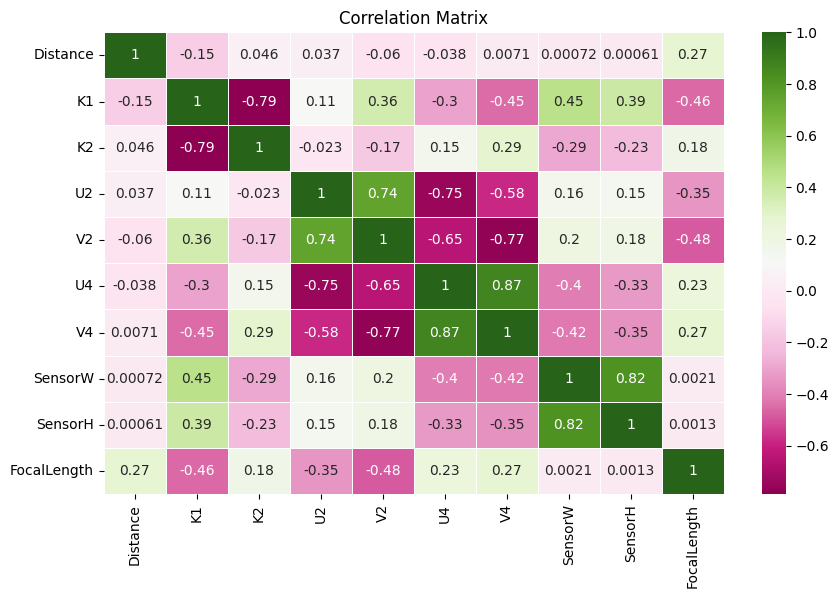

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix to check the relationships between the variables
corr_matrix = training_data[['Distance', 'K1', 'K2', 'U2', 'V2', 'U4', 'V4', 'SensorW', 'SensorH', 'FocalLength']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='PiYG', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


In [39]:
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def save_object(obj, path, obj_name):
    """Save a Python object using joblib."""
    try:
        joblib.dump(obj, path)
        print(f"{obj_name} saved at {path}")
    except Exception as e:
        print(f"Failed to save {obj_name}: {e}")

def plot_predictions(y_test, y_pred, target_name, ax):
    """Plot predictions vs actuals."""
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    ax.set_xlabel(f'Actual {target_name}')
    ax.set_ylabel(f'Predicted {target_name}')
    ax.set_title(f'{target_name}: Actual vs Predicted\nMSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}')

# (k1 k2 distance focal-length) -> (sensor-width sensor-height)

SensorW - MSE: 0.05309845256798069, R2: 0.9217697761910458, MAE: 0.13320500260517323
SensorH - MSE: 0.037226375488184464, R2: 0.8281056347911462, MAE: 0.13828894879384693


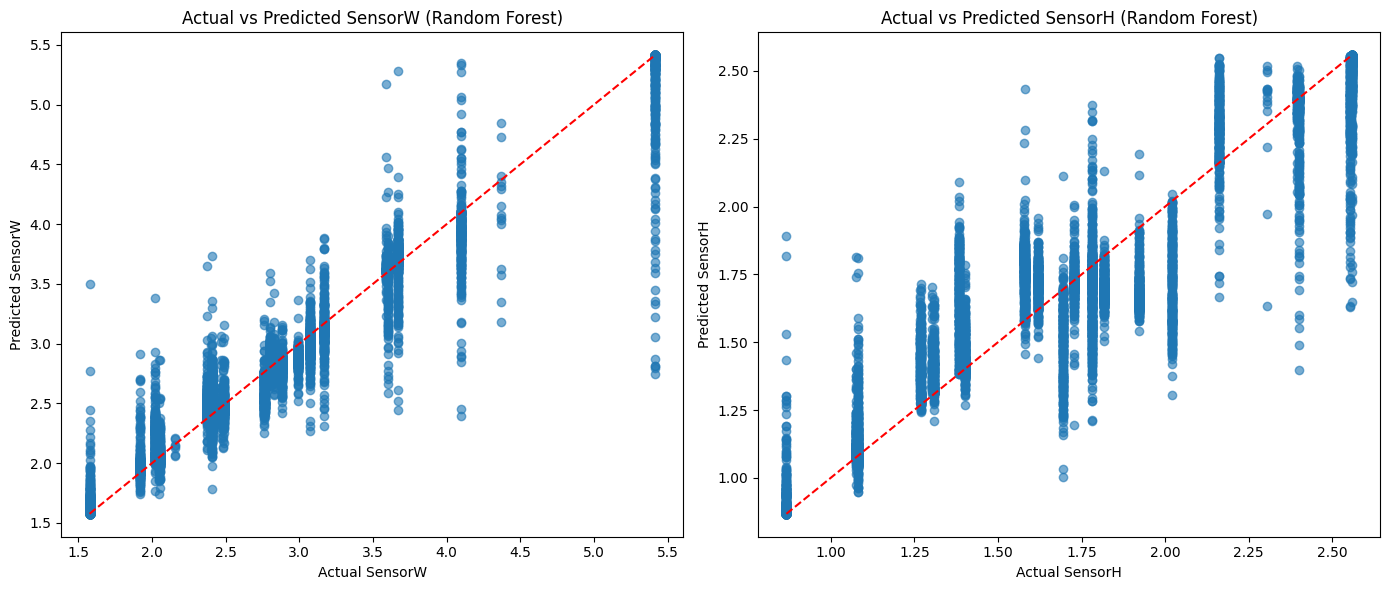

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load the dataset
file_path = output_csv_path
data = pd.read_csv(file_path)

# Defining features and targets
features = data[['Distance', 'K1', 'K2', 'FocalLength']]
target_w = data['SensorW']
target_h = data['SensorH']

# Splitting the data into training and testing sets
X_train, X_test, y_train_w, y_test_w = train_test_split(features, target_w, test_size=0.2, random_state=42)
_, _, y_train_h, y_test_h = train_test_split(features, target_h, test_size=0.2, random_state=42)

# Initializing and training the RandomForestRegressor for SensorW
rf_model_w = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_w.fit(X_train, y_train_w)

# Predicting SensorW using Random Forest
rf_predictions_w = rf_model_w.predict(X_test)

# Evaluating the Random Forest model for SensorW
rf_mse_w = mean_squared_error(y_test_w, rf_predictions_w)
rf_r2_w = r2_score(y_test_w, rf_predictions_w)
rf_mae_w = mean_absolute_error(y_test_w, rf_predictions_w)

# Initializing and training the RandomForestRegressor for SensorH
rf_model_h = RandomForestRegressor(n_estimators=144, random_state=42)
rf_model_h.fit(X_train, y_train_h)

# Predicting SensorH using Random Forest
rf_predictions_h = rf_model_h.predict(X_test)

# Evaluating the Random Forest model for SensorH
rf_mse_h = mean_squared_error(y_test_h, rf_predictions_h)
rf_r2_h = r2_score(y_test_h, rf_predictions_h)
rf_mae_h = mean_absolute_error(y_test_h, rf_predictions_h)

# Displaying the evaluation metrics
print(f"SensorW - MSE: {rf_mse_w}, R2: {rf_r2_w}, MAE: {rf_mae_w}")
print(f"SensorH - MSE: {rf_mse_h}, R2: {rf_r2_h}, MAE: {rf_mae_h}")

# Plotting the predictions vs actual values for SensorW and SensorH
plt.figure(figsize=(14, 6))

# SensorW plot
plt.subplot(1, 2, 1)
plt.scatter(y_test_w, rf_predictions_w, alpha=0.6)
plt.plot([y_test_w.min(), y_test_w.max()], [y_test_w.min(), y_test_w.max()], 'r--')
plt.xlabel('Actual SensorW')
plt.ylabel('Predicted SensorW')
plt.title('Actual vs Predicted SensorW (Random Forest)')

# SensorH plot
plt.subplot(1, 2, 2)
plt.scatter(y_test_h, rf_predictions_h, alpha=0.6)
plt.plot([y_test_h.min(), y_test_h.max()], [y_test_h.min(), y_test_h.max()], 'r--')
plt.xlabel('Actual SensorH')
plt.ylabel('Predicted SensorH')
plt.title('Actual vs Predicted SensorH (Random Forest)')

plt.tight_layout()
plt.show()


# ONE LENS
## (sensor-width sensor-height distance) -> (k1 k2)

In [42]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

def train_lens(lens, training_data):
    # Prepare the data for training
    X = training_data[['SensorW', 'SensorH', 'Distance']]
    y = training_data[['K1', 'K2']]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define parameter grid for RandomizedSearchCV
    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }

    models = {}

    # Train models for each target
    for target in ['K1', 'K2']:
        print(f"Training model for {target}...")
        base_model = XGBRegressor(random_state=42)
        random_search = RandomizedSearchCV(estimator=base_model, param_distributions=param_grid,
                                           n_iter=20, scoring='neg_mean_absolute_error',
                                           cv=3, verbose=1, random_state=42, n_jobs=-1)
        random_search.fit(X_train_scaled, y_train[target])
        model = random_search.best_estimator_

        # Store the model
        models[target] = model

        # Make predictions
        y_pred = model.predict(X_test_scaled)

    # Plot predictions vs actuals
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'Predictions vs Actuals for {lens}')
    plot_predictions(y_test['K1'], models['K1'].predict(X_test_scaled), 'K1', axes[0])
    plot_predictions(y_test['K2'], models['K2'].predict(X_test_scaled), 'K2', axes[1])
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return models, scaler


In [124]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred, label, ax):
    """Utility function to plot predictions vs actuals."""
    ax.scatter(y_true, y_pred, alpha=0.5)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    ax.set_title(f'{label} Predictions vs Actuals')
    ax.set_xlabel('Actuals')
    ax.set_ylabel('Predictions')

def train_lens2(lens, training_data):
    # Prepare the data for training
    X = training_data[['SensorW', 'SensorH', 'Distance']]
    y = training_data[['K1', 'K2']]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Scale the target K2 using MinMaxScaler
    scaler_y_K2 = MinMaxScaler(feature_range=(0, 1))  # Specify range if needed
    y_train['K2'] = scaler_y_K2.fit_transform(y_train[['K2']])
    y_test['K2'] = scaler_y_K2.transform(y_test[['K2']])

    # Define parameter grid for RandomizedSearchCV
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'reg_alpha': [0.1, 0.5, 1.0],   # L1 regularization
        'reg_lambda': [0.1, 0.5, 1.0]    # L2 regularization
    }

    models = {}

    # Train models for each target
    for target in ['K1', 'K2']:
        print(f"Training model for {target}...")
        base_model = XGBRegressor(random_state=42)
        random_search = RandomizedSearchCV(
            estimator=base_model,
            param_distributions=param_grid,
            n_iter=20,
            scoring='neg_mean_absolute_error',
            cv=5,
            verbose=1,
            random_state=42,
            n_jobs=-1
        )
        
        # Fit RandomizedSearchCV to find the best parameters
        random_search.fit(X_train_scaled, y_train[target])
        
        # Get the best parameters and create a new model
        best_params = random_search.best_params_
        model = XGBRegressor(**best_params, random_state=42, early_stopping_rounds=10)
        
        # Fit the model with early stopping
        model.fit(
            X_train_scaled, y_train[target],
            eval_set=[(X_test_scaled, y_test[target])],
            verbose=False
        )
        
        # Store the model
        models[target] = model

    # Plot predictions vs actuals
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'Predictions vs Actuals for {lens}')

    # Plot for K1 (no scaling applied here)
    plot_predictions(
        y_test['K1'], 
        models['K1'].predict(X_test_scaled), 
        'K1', 
        axes[0]
    )

    # Plot for K2 (with MinMaxScaler inverse transformation)
    y_pred_k2_original = scaler_y_K2.inverse_transform(
        models['K2'].predict(X_test_scaled).reshape(-1, 1)
    )
    plot_predictions(
        y_test['K2'], 
        y_pred_k2_original, 
        'K2', 
        axes[1]
    )

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return models, scaler_X, scaler_y_K2


## Save ONNX and scaler

In [ ]:
import xgboost as xgb
from onnxmltools.convert.common.data_types import FloatTensorType
from onnxmltools.convert import convert_xgboost

def save_xgboost_model_to_onnx(model, model_path, input_shape):
    """
    Convert a trained XGBoost model to ONNX format and save it to disk.
    
    Parameters:
    - model: The trained XGBoost model to convert.
    - model_path: Path to save the ONNX model.
    - input_shape: Shape of the input data, required for ONNX conversion.
    """
    try:
        # Define initial types for ONNX conversion
        initial_type = [('float_input', FloatTensorType([None, input_shape]))]
        
        # Convert the XGBoost model to ONNX
        onnx_model = convert_xgboost(model, initial_types=initial_type)
        
        # Save the ONNX model to file
        with open(model_path, "wb") as f:
            f.write(onnx_model.SerializeToString())
        
        print(f"ONNX model saved at {model_path}")
    except Exception as e:
        print(f"Failed to convert XGBoost model to ONNX: {e}")





## Do the training - ONE LENS

Training model for focal length 1.83mm
Training model for K1...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training model for K2...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


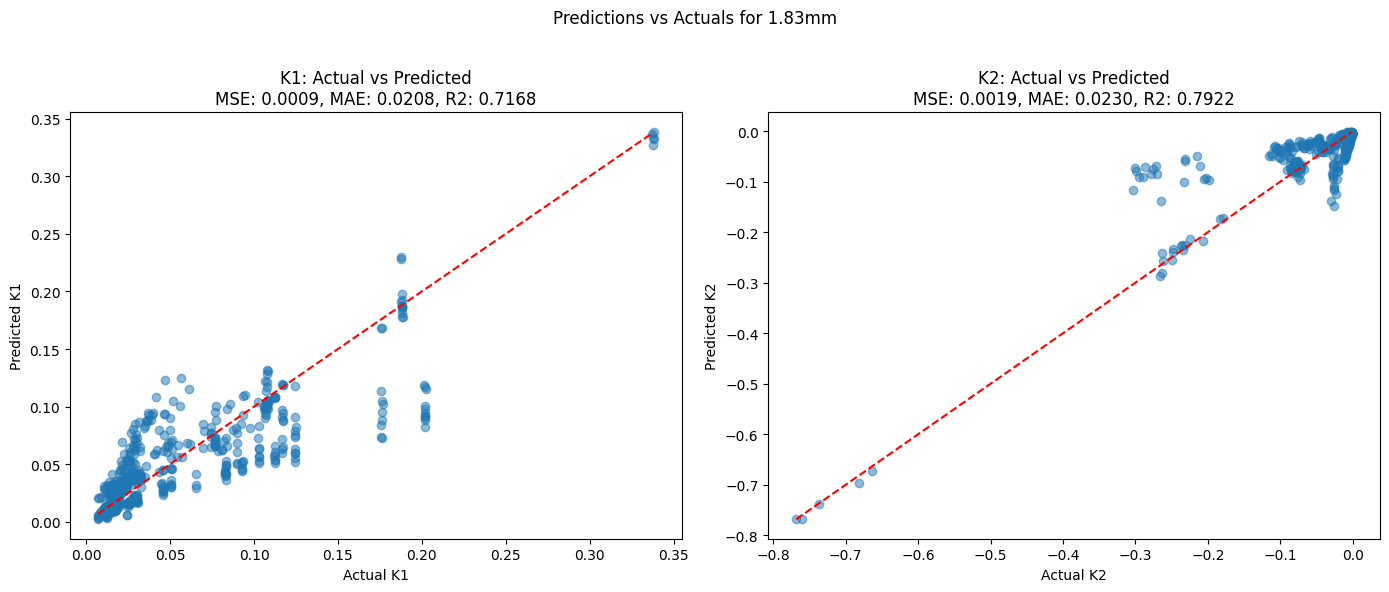

Scaler saved at g:\My Drive\Projects\camflex\models\1.83mm_scaler.pkl
ONNX model saved at g:\My Drive\Projects\camflex\models\1.83mm_K1_model.onnx
ONNX model saved at g:\My Drive\Projects\camflex\models\1.83mm_K2_model.onnx
K1 Model saved at g:\My Drive\Projects\camflex\models\1.83mm_K1_model.pkl
K2 Model saved at g:\My Drive\Projects\camflex\models\1.83mm_K2_model.pkl
Model training and ONNX conversion completed for focal length 1.83mm.


In [49]:
def train_lens_and_save(lens, training_data, modeldir):
    lens_name = lens + 'mm'

    # Train the models
    models, scaler = train_lens(lens_name, training_data) ######################################### train_lens2
    
    # Save the scaler
    scaler_path = modeldir / (lens_name + '_scaler.pkl')
    save_object(scaler, scaler_path, "Scaler")

    # Save models as ONNX
    for param, model in models.items():
        save_xgboost_model_to_onnx(model, modeldir / (lens_name + '_' + param + '_model.onnx'), input_shape=training_data[['SensorW', 'SensorH', 'Distance']].shape[1])

    # Save the models as joblib files
    for param, model in models.items():
        model_path = modeldir / (lens_name + '_' + param + '_model.pkl')
        save_object(model, model_path, f"{param} Model")
    
    return models

# Get unique focal lengths
focal_lengths = training_data['FocalLength'].unique()

# Loop through each unique focal length
for focal_length in focal_lengths:
    # Filter the training data for the current focal length
    focal_data = training_data[training_data['FocalLength'] == focal_length]

    # Train the model using the filtered data and save as ONNX
    print(f"Training model for focal length {focal_length}mm")
    train_lens_and_save(lens=str(focal_length), training_data=focal_data, modeldir=modeldir)

    print(f"Model training and ONNX conversion completed for focal length {focal_length}mm.")
    break # Uncomment to only process the first focal length


# Given K1, K2, Distance, Focal length -> predict Sensor width and height using ALL THE DATA

SensorW - MSE: 0.003906785176132784, R2: 0.9942147494974145, MAE: 0.028913286618089677
SensorH - MSE: 0.0036947434637861296, R2: 0.9828365234707481, MAE: 0.03236019674614597


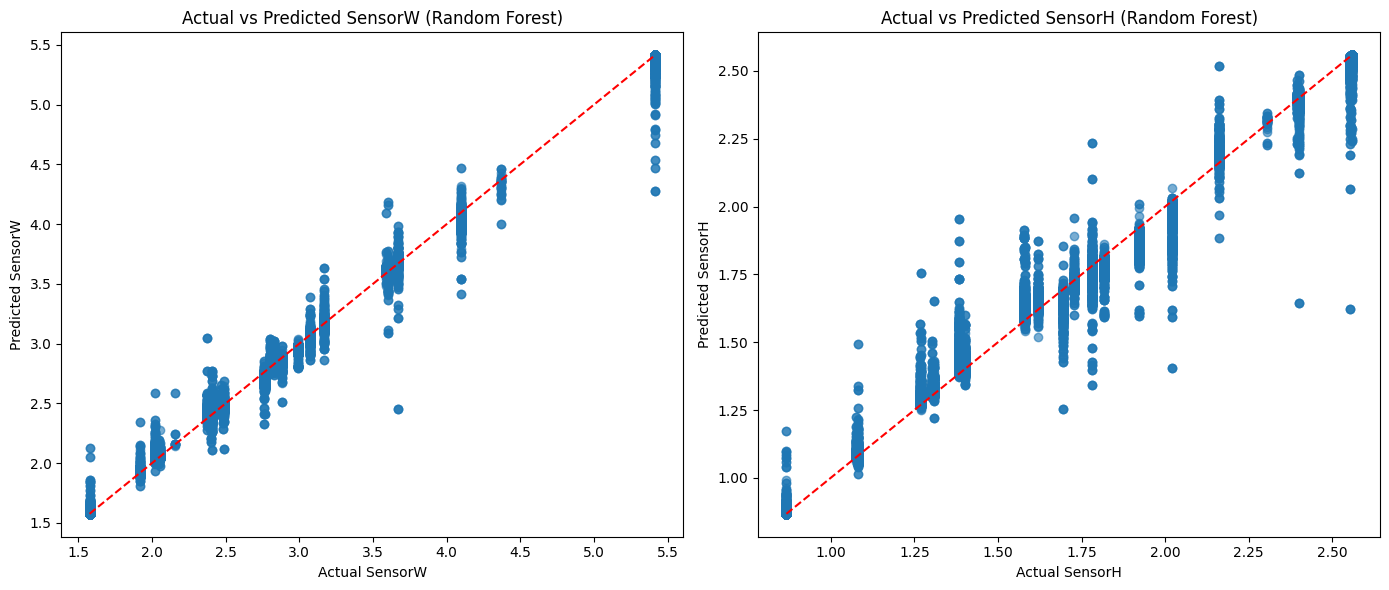

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load the dataset
file_path = output_csv_path
data = pd.read_csv(file_path)

# Defining features and targets
features = data[['Distance', 'K1', 'K2', 'FocalLength']]
target_w = data['SensorW']
target_h = data['SensorH']

# Splitting the data into training and testing sets
X_train, X_test, y_train_w, y_test_w = train_test_split(features, target_w, test_size=0.2, random_state=42)
_, _, y_train_h, y_test_h = train_test_split(features, target_h, test_size=0.2, random_state=42)

# Initializing and training the RandomForestRegressor for SensorW
rf_model_w = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_w.fit(X_train, y_train_w)

# Predicting SensorW using Random Forest
rf_predictions_w = rf_model_w.predict(X_test)

# Evaluating the Random Forest model for SensorW
rf_mse_w = mean_squared_error(y_test_w, rf_predictions_w)
rf_r2_w = r2_score(y_test_w, rf_predictions_w)
rf_mae_w = mean_absolute_error(y_test_w, rf_predictions_w)

# Initializing and training the RandomForestRegressor for SensorH
rf_model_h = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_h.fit(X_train, y_train_h)

# Predicting SensorH using Random Forest
rf_predictions_h = rf_model_h.predict(X_test)

# Evaluating the Random Forest model for SensorH
rf_mse_h = mean_squared_error(y_test_h, rf_predictions_h)
rf_r2_h = r2_score(y_test_h, rf_predictions_h)
rf_mae_h = mean_absolute_error(y_test_h, rf_predictions_h)

# Displaying the evaluation metrics
print(f"SensorW - MSE: {rf_mse_w}, R2: {rf_r2_w}, MAE: {rf_mae_w}")
print(f"SensorH - MSE: {rf_mse_h}, R2: {rf_r2_h}, MAE: {rf_mae_h}")

# Plotting the predictions vs actual values for SensorW and SensorH
plt.figure(figsize=(14, 6))

# SensorW plot
plt.subplot(1, 2, 1)
plt.scatter(y_test_w, rf_predictions_w, alpha=0.6)
plt.plot([y_test_w.min(), y_test_w.max()], [y_test_w.min(), y_test_w.max()], 'r--')
plt.xlabel('Actual SensorW')
plt.ylabel('Predicted SensorW')
plt.title('Actual vs Predicted SensorW (Random Forest)')

# SensorH plot
plt.subplot(1, 2, 2)
plt.scatter(y_test_h, rf_predictions_h, alpha=0.6)
plt.plot([y_test_h.min(), y_test_h.max()], [y_test_h.min(), y_test_h.max()], 'r--')
plt.xlabel('Actual SensorH')
plt.ylabel('Predicted SensorH')
plt.title('Actual vs Predicted SensorH (Random Forest)')

plt.tight_layout()
plt.show()
